In [58]:
import os 
import pandas as pd  
from torchtext.data.utils import get_tokenizer
import torch
from collections import Counter
from torchtext.vocab import Vocab
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from skimage import io

In [53]:
en_tokenizer = get_tokenizer('spacy', language='en')

def build_vocab(sentences):
    counter = Counter()
    for string_ in sentences:
        counter.update(en_tokenizer(string_))
    return Vocab(counter, specials=['<UNK>', '<PAD>', '<SOS>', '<EOS>'])

def data_process(sentence, vocab):
    vocab_tensor = torch.tensor([vocab[token] for token in en_tokenizer(sentence)],
                            dtype=torch.long)
    return vocab_tensor

C:\Users\Ayush\AppData\Local\Programs\Python\Python39\lib\site-packages\torchtext\data\utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [65]:
class Flickr8k(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.imgs = self.csv_frame["image"]
        self.captions = self.csv_frame["caption"]
        self.vocab = build_vocab(self.captions.to_list())

    def __len__(self):
        return len(self.csv_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.imgs[idx])
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
        tokenized_caption = data_process(self.captions[idx], self.vocab)
        
        return image, tokenized_caption
        

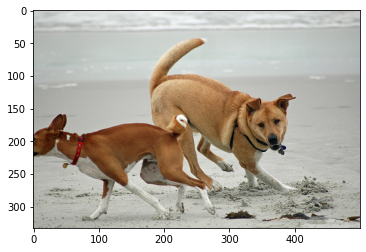

In [74]:
if __name__ == "__main__":
    data = Flickr8k(csv_file="flickr8k/captions.txt", root_dir="flickr8k/images")
    plt.imshow(data[100][0])